In [5]:
import time

from data_stream import StreamReceiver

from simulation.webots.controllers.ardupilot_vehicle_controller.drone_data import RangefinderData, CameraData, FDMData, GimbalAxisData, GimbalData, DroneData
from mavlink.mavlink import MAVLinkController, DataAcquisitionThread
from mavlink.mavlink.processor import DataProcessor, GimbalProcessor, GlobalPositionProcessor, AttitudeProcessor, LocalPositionProcessor
from mavlink.mavlink import Quaternion
from math import atan, tan, radians, degrees
import time
import numpy
from mavlink.mavlink.data import Gimbal
import cv2
from data_stream import StreamReceiver
from simulation.webots.controllers.ardupilot_vehicle_controller.drone_data import RangefinderData, CameraData, FDMData, GimbalAxisData, GimbalData, DroneData
import math
from matplotlib import pyplot as plt
from ultralytics import YOLO
import random
from deep_sort.deep_sort.tracker import Tracker
from deep_sort.deep_sort.deep.extractor import Extractor
from deep_sort.deep_sort.deep.configuration import ResNetConfiguration
from deep_sort.deep_sort.deep.weights import RESNET18_WEIGHTS


mavlink_connection = MAVLinkController("udp:0.0.0.0:14550")

attitude_processor = AttitudeProcessor()
global_position_processor = GlobalPositionProcessor()
local_position_processor = LocalPositionProcessor()
gimbal_processor = GimbalProcessor()

acquisition_thread = DataAcquisitionThread(mavlink_connection, [attitude_processor, global_position_processor, local_position_processor, gimbal_processor])
acquisition_thread.start()


host = "192.168.0.107"
port = 5588
stream_receiver = StreamReceiver(host, port)

In [11]:
import json


def store_data():
    time_range = 60 * 5
    start_time = time.time()
    
    json_dict = {}
    i = 0
    while True:
        global_position = global_position_processor.queue.get_latest()
        gimbal = gimbal_processor.queue.get_latest()
        attitude = attitude_processor.queue.get_latest()
        
        data = stream_receiver.get_data()
                
        json_dict[i] = {
            "time": time.time(),
            "gimbal": {
                "timestamp": gimbal.timestamp,
                "flags": gimbal.flags,
                "quaternion": gimbal.quaternion.to_array()
            },
            "global_position": {
                "timestamp": global_position.timestamp,
                "latitude": global_position.latitude,
                "longitude": global_position.longitude,
                "altitude": global_position.altitude,
                "relative_altitude": global_position.relative_altitude,
                "vx": global_position.vx,
                "vy": global_position.vy,
                "vz": global_position.vz,
                "heading": global_position.heading
            },
            "attitude": {
                "timestamp": attitude.timestamp,
                "roll": attitude.roll,
                "pitch": attitude.pitch,
                "yaw": attitude.yaw,
                "roll_speed": attitude.roll_speed,
                "pitch_speed": attitude.pitch_speed,
                "yaw_speed": attitude.yaw_speed
            },
            "webots_data": data
        }
        i += 1
        
        time.sleep(1 / (30 * 1.5))
        
        current_time = time.time()
        
        if current_time - start_time >= time_range:
            break
        
        print(f"Time {current_time - start_time} of {time_range}")
        
    file_name = "data_new.json"
    with open(file_name, "w") as file:
        json.dump(json_dict, file, indent=4)
        

store_data()


Time 0.05600237846374512 of 300
Time 0.12200212478637695 of 300
Time 0.1690056324005127 of 300
Time 0.2310023307800293 of 300
Time 0.2816193103790283 of 300
Time 0.3399984836578369 of 300
Time 0.39299726486206055 of 300
Time 0.44699835777282715 of 300
Time 0.5079991817474365 of 300
Time 0.6445138454437256 of 300
Time 0.7275116443634033 of 300
Time 0.779512882232666 of 300
Time 0.8335175514221191 of 300
Time 0.8840830326080322 of 300
Time 0.9470853805541992 of 300
Time 1.046074628829956 of 300
Time 1.1220784187316895 of 300
Time 1.1720802783966064 of 300
Time 1.2486484050750732 of 300
Time 1.3036506175994873 of 300
Time 1.3656506538391113 of 300
Time 1.417651653289795 of 300
Time 1.4681651592254639 of 300
Time 1.5161676406860352 of 300
Time 1.586172103881836 of 300
Time 1.6491672992706299 of 300
Time 1.7361702919006348 of 300
Time 1.854175329208374 of 300
Time 1.903167724609375 of 300
Time 1.953169345855713 of 300
Time 2.0051674842834473 of 300
Time 2.0601918697357178 of 300
Time 2.1111

In [2]:
import json

file_name = "data.json"

with open(file_name, "r") as file:
    data = json.load(file)
    

Frame 1 out of 5351
Frame 2 out of 5351
Frame 3 out of 5351
Frame 4 out of 5351
Frame 5 out of 5351
Frame 6 out of 5351
Frame 7 out of 5351
Frame 8 out of 5351
Frame 9 out of 5351
Frame 10 out of 5351
Frame 11 out of 5351
Frame 12 out of 5351
Frame 13 out of 5351
Frame 14 out of 5351
Frame 15 out of 5351
Frame 16 out of 5351
Frame 17 out of 5351
Frame 18 out of 5351
Frame 19 out of 5351
Frame 20 out of 5351
Frame 21 out of 5351
Frame 22 out of 5351
Frame 23 out of 5351
Frame 24 out of 5351
Frame 25 out of 5351
Frame 26 out of 5351
Frame 27 out of 5351
Frame 28 out of 5351
Frame 29 out of 5351
Frame 30 out of 5351
Frame 31 out of 5351
Frame 32 out of 5351
Frame 33 out of 5351
Frame 34 out of 5351
Frame 35 out of 5351
Frame 36 out of 5351
Frame 37 out of 5351
Frame 38 out of 5351
Frame 39 out of 5351
Frame 40 out of 5351
Frame 41 out of 5351
Frame 42 out of 5351
Frame 43 out of 5351
Frame 44 out of 5351
Frame 45 out of 5351
Frame 46 out of 5351
Frame 47 out of 5351
Frame 48 out of 5351
F

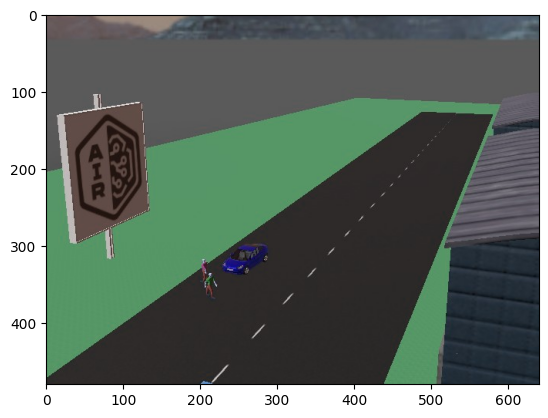

In [10]:
from mavlink.mavlink.data import Attitude, GlobalPosition, Quaternion, Gimbal
import cv2


def get_objects(data):
    quaternion = Quaternion(data['gimbal']['quaternion'])
    
    gimbal = Gimbal(
        timestamp=data['gimbal']['timestamp'],
        flags=data['gimbal']['flags'],
        quaternion=quaternion
    )
    
    global_position = GlobalPosition(
        timestamp=data['global_position']['timestamp'],
        latitude=data['global_position']['latitude'],
        longitude=data['global_position']['longitude'],
        altitude=data['global_position']['altitude'],
        relative_altitude=data['global_position']['relative_altitude'],
        vx=data['global_position']['vx'],
        vy=data['global_position']['vy'],
        vz=data['global_position']['vz'],
        heading=data['global_position']['heading']
    )

    attitude = Attitude(
        timestamp=data['attitude']['timestamp'],
        roll=data['attitude']['roll'],
        pitch=data['attitude']['pitch'],
        yaw=data['attitude']['yaw'],
        roll_speed=data['attitude']['roll_speed'],
        pitch_speed=data['attitude']['pitch_speed'],
        yaw_speed=data['attitude']['yaw_speed']
    )

    all_objects = {
        "gimbal": gimbal,
        "global_position": global_position,
        "attitude": attitude,
        "webots": DroneData.from_json(data['webots_data'])
    }
    
    return all_objects



# drone_data = get_data(data["0"])
# print(drone_data["webots"].camera.frame.shape[:2])
# plt.imshow(drone_data["webots"].camera.frame)

fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter("output_video_new.avi", fourcc, 30, (640, 480))

for key, value in data.items():
    frame = get_objects(value)["webots"].camera.frame
                    
    out.write(frame)

    print(f"Frame {int(key) + 1} out of {len(data)}")

out.release()

plt.imshow(frame)

GIMBAL [0.0, -34.99999808531533, 0.0]


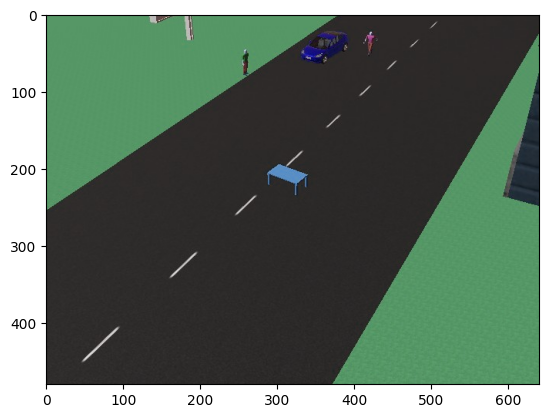

In [2]:
latest_data = gimbal_processor.queue.get_latest()
if latest_data:
    print("GIMBAL", [math.degrees(axis) for axis in latest_data.quaternion.to_euler()])

mavlink_connection.gimbal.set_angles(
    roll=0,
    pitch=-15,
    yaw=0
)

data = stream_receiver.get_data()
drone_data = DroneData.from_json(data)
camera_frame = drone_data.camera.frame

plt.imshow(camera_frame)

In [80]:
data = stream_receiver.get_data()
drone_data = DroneData.from_json(data)
camera_frame = drone_data.camera.frame

model = YOLO("yolov8n-visdrone.pt")

detection_threshold = 0.01

resnet = ResNetConfiguration(
    base="resnet18",
    weights_path=RESNET18_WEIGHTS,
    use_cuda=True
)
extractor = Extractor(model=resnet, batch_size=4)

tracker = Tracker(
    feature_extractor=extractor
)

colors = [(
    random.randint(0, 255),
    random.randint(0, 255),
    random.randint(0, 255)) for j in range(10)
]

True

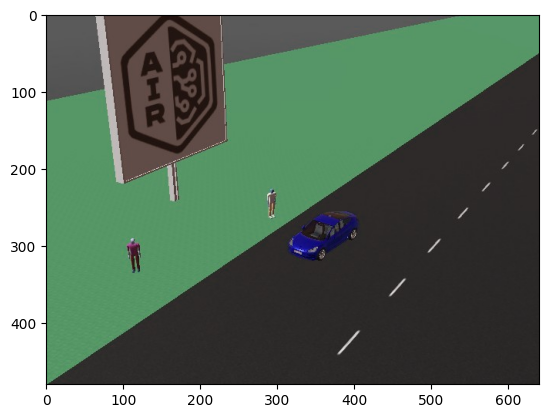

In [86]:
plt.imshow(camera_frame)
cv2.imwrite("camera_frame.png", camera_frame)

[64, 0, 238, 220, 0.9576498866081238, 11, 'stop sign']
[313, 254, 407, 320, 0.9402777552604675, 2, 'car']
[104, 290, 122, 335, 0.8864226937294006, 0, 'person']
[286, 225, 299, 265, 0.8351688385009766, 0, 'person']


True

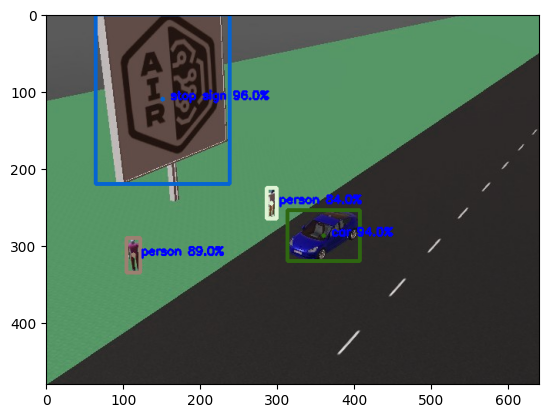

In [87]:
results = model.predict(
    camera_frame,
    verbose=False
)
result = results[0]

yolo_frame = camera_frame.copy()
detections = []
class_list = [0, 2]
for i, result in enumerate(result.boxes.data.tolist()):    
    x1, y1, x2, y2, score, class_id = result
    x1 = int(x1)
    x2 = int(x2)
    y1 = int(y1)
    y2 = int(y2)
    class_id = int(class_id)    
    
    print([x1, y1, x2, y2, score, class_id, model.names[class_id]])
    
    if class_id in class_list:
        detections.append([x1, y1, x2, y2, score, class_id])
    
    color = colors[i % len(colors)]

    cv2.rectangle(
        yolo_frame,
        (int(x1), int(y1)),
        (int(x2), int(y2)),
        color,
        3
    )
    
    cx = int((x1 + x2) / 2)
    cy = int((y1 + y2) / 2)
    
    cv2.circle(
        yolo_frame,
        (cx, cy),
        3,
        color,
        -1
    )
    
    cv2.putText(
        yolo_frame,
        f"{model.names[class_id]} {round(score * 100, 0)}%",
        (cx + 10, cy),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.5,
        (0, 0, 255),
        2
    )
    
plt.imshow(yolo_frame)
cv2.imwrite("yolo_frame.png", yolo_frame)

313.0 254.0 407.0 320.0 1 2
104.0 290.0 122.0 335.0 2 0
286.0 225.0 299.0 265.0 3 0


True

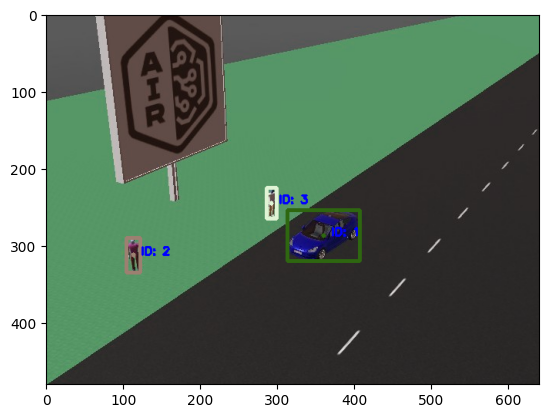

In [88]:
tracker = Tracker(
    feature_extractor=extractor
)

for i in range(10):
    tracker.update(camera_frame, detections)

sort_frame = camera_frame.copy()

for track in tracker.tracks:
    x1, y1, x2, y2 = track.to_tlbr()
    track_id = track.track_id
    class_id = track.class_id

    print(
        x1, y1, x2, y2, track_id, class_id
    )

    color = colors[track_id % len(colors)]

    cv2.rectangle(
        sort_frame,
        (int(x1), int(y1)),
        (int(x2), int(y2)),
        color,
        3
    )

    cx = int((x1 + x2) / 2)
    cy = int((y1 + y2) / 2)

    cv2.circle(
        sort_frame,
        (cx, cy),
        3,
        color,
        -1
    )

    cv2.putText(
        sort_frame,
        f"ID: {track_id}",
        (cx + 10, cy),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.5,
        (0, 0, 255),
        2
    )

plt.imshow(sort_frame)
cv2.imwrite("sort_frame.png", sort_frame)

In [89]:
import rasterio
from rasterio.enums import Resampling
from rasterio.warp import transform


def find_elevation(latitude, longitude, file_path="S36E149.hgt"):
    with rasterio.open(file_path) as src:
        transformed_point = transform(
            {'init': 'epsg:4326'},
            src.crs,
            [longitude], [latitude]
        )
        
        row, col = src.index(transformed_point[0][0], transformed_point[1][0])
        elevation = src.read(1, window=rasterio.windows.Window(col, row, 1, 1), resampling=Resampling.nearest)
        
        return elevation[0][0]


def find_target_location(global_position, gimbal, offset=None):    
    roll, pitch, yaw = gimbal.quaternion.to_euler()
    heading = math.radians(global_position.heading)  
    yaw = yaw + heading
    
    if offset:
        offset_roll, offset_pitch, offset_yaw = offset
        
        roll += offset_roll
        pitch += offset_pitch
        yaw += offset_yaw
    
    direction_vector = numpy.array([
        math.cos(pitch) * math.sin(yaw),
        math.cos(pitch) * math.cos(yaw),
        math.sin(pitch)
    ])
    
    distance_to_ground = global_position.relative_altitude / -direction_vector[2]
    
    target_enu = direction_vector * distance_to_ground
    
    earth_radius = 6371000
    latitude_change = target_enu[1] / earth_radius
    longitude_change = target_enu[0] / (earth_radius * math.cos(math.radians(global_position.latitude)))
    
    target_latitude = global_position.latitude + math.degrees(latitude_change)
    target_longitude = global_position.longitude + math.degrees(longitude_change)
    target_altitude = find_elevation(target_latitude, target_longitude)
    
    return target_latitude, target_longitude, target_altitude


def distance_between_locations(lat1, lon1, alt1, lat2, lon2, alt2):
    phi1, phi2 = math.radians(lat1), math.radians(lat2)
    lambda1, lambda2 = math.radians(lon1), math.radians(lon2)
    
    delta_phi = phi2 - phi1
    delta_lambda = lambda2 - lambda1
    delta_alt = alt2 - alt1
    
    a = math.sin(delta_phi / 2.0) ** 2 + math.cos(phi1) * math.cos(phi2) * math.sin(delta_lambda / 2.0) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    earth_radius = 6371000
    distance = earth_radius * c
    
    total_distance = math.sqrt(distance ** 2 + delta_alt ** 2)
    
    return total_distance


drone_latitude: -35.3633503 drone_longitude: 149.1653247 drone_altitude: 598.89
gimbal: Quaternion(w=0.8692038059234619, x=-0.09205786138772964, y=-0.17684151232242584, z=-0.4524788558483124)
target_latitude: -35.36310047244026 target_longitude: 149.16520322868328 target_altitude: 584 distance: 33.387796183317576
target_latitude: -35.36315688841991 target_longitude: 149.16513273063202 target_altitude: 585 distance: 30.959383362273467
target_latitude: -35.363073909805834 target_longitude: 149.16515640057264 target_altitude: 584 distance: 37.4051866196173


True

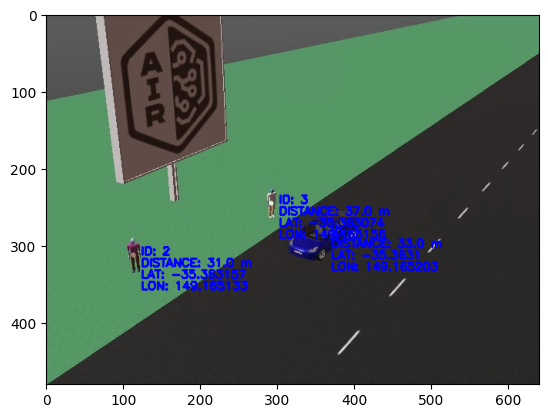

In [94]:
fov_vertical = 2 * atan(tan(drone_data.camera.fov * 0.5) * (drone_data.camera.height / drone_data.camera.width))

def find_center(x1, y1, x2, y2):
    center_x = (x1 + x2) // 2
    center_y = (y1 + y2) // 2
    
    return center_x, center_y


global_position = global_position_processor.queue.get_latest()
gimbal = gimbal_processor.queue.get_latest()

print("drone_latitude:", global_position.latitude, 
      "drone_longitude:", global_position.longitude, 
      "drone_altitude:", global_position.altitude)
print("gimbal:", gimbal.quaternion)

geo_frame = camera_frame.copy()

for track in tracker.tracks:
    x1, y1, x2, y2 = track.to_tlbr()
    track_id = track.track_id
    class_id = track.class_id
    
    target_center_x, target_center_y = find_center(x1, y1, x2, y2)
    
    image_center_x, image_center_y = find_center(0, 0, drone_data.camera.width, drone_data.camera.height)
    
    offset_x = target_center_x - image_center_x
    offset_y = target_center_y - image_center_y
    
    offset_yaw = (offset_x / drone_data.camera.width) * drone_data.camera.fov
    offset_pitch = -(offset_y / drone_data.camera.height) * fov_vertical    
    
    target_latitude, target_longitude, target_altitude = find_target_location(
        global_position, 
        gimbal, 
        offset=[0, offset_pitch, offset_yaw]
    )
    distance = distance_between_locations(
        target_latitude, target_longitude, target_altitude, 
        global_position.latitude, global_position.longitude, global_position.altitude
    )
    
    print("target_latitude:", target_latitude, "target_longitude:", target_longitude, "target_altitude:", target_altitude, "distance:", distance)
    
    color = colors[track_id % len(colors)]

    # cv2.rectangle(
    #     geo_frame,
    #     (int(x1), int(y1)),
    #     (int(x2), int(y2)),
    #     color,
    #     3
    # )

    cx = int((x1 + x2) / 2)
    cy = int((y1 + y2) / 2)

    cv2.circle(
        geo_frame,
        (cx, cy),
        3,
        color,
        -1
    )

    cv2.putText(
        geo_frame,
        f"ID: {track_id}",
        (cx + 10, cy),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.5,
        (0, 0, 255),
        2
    )
    cv2.putText(
        geo_frame,
        f"DISTANCE: {round(distance, 0)} m",
        (cx + 10, cy + 15),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.5,
        (0, 0, 255),
        2
    )
    cv2.putText(
        geo_frame,
        f"LAT: {round(target_latitude, 6)}",
        (cx + 10, cy + 30),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.5,
        (0, 0, 255),
        2
    )
    cv2.putText(
        geo_frame,
        f"LON: {round(target_longitude, 6)}",
        (cx + 10, cy + 45),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.5,
        (0, 0, 255),
        2
    )
    
    
    
plt.imshow(geo_frame)
cv2.imwrite("geo_frame.png", geo_frame)

In [91]:
print(global_position)
print(gimbal)

GlobalPosition(timestamp=1714531619.9505506, latitude=-35.3633503, longitude=149.1653247, altitude=598.89, relative_altitude=14.82, vx=-0.01, vy=0.0, vz=0.0, heading=17.73)
Gimbal(timestamp=1714531616.5303, flags=44, quaternion=Quaternion(w=0.8692038059234619, x=-0.09205786138772964, y=-0.17684151232242584, z=-0.4524788558483124))
